![Astrofisica Computacional](../../logo.PNG)

---
## 01. Clustering. Galaxies

Eduard Larrañaga (ealarranaga@unal.edu.co)

---


### About this notebook

We train a non-supervised clustering algorithm using photometric information of galaxies.


---

---

## The Data

We will use a sample of approximately 10000 galaxies from the SDSS including photometric data (color indices and Petrosian flux). For information about these quantities see [this page](https://www.sdss.org/dr12/algorithms/classify/).

The dataset is downloaded from the SDSS using [astroquery](https://astroquery.readthedocs.io/en/latest/) giving an object of the type 
`astropy.table`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.sdss import SDSS  # enables direct queries to the SDSS database

GALquery = """SELECT TOP 10000 
             p.dered_u - p.dered_g as ug, p.dered_g - p.dered_r as gr, 
             p.dered_g - p.dered_i as gi, p.dered_g - p.dered_z as gz,             
             p.petroRad_i, p.petroR50_i, p.deVAB_i
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND p.type = 3
               """
SDSSgals = SDSS.query_sql(GALquery)
SDSSgals

ug,gr,gi,gz,petroRad_i,petroR50_i,deVAB_i
float64,float64,float64,float64,float64,float64,float64
1.121708,1.39658,2.130693,2.535936,4.519153,1.872421,0.5599636
1.792809,1.768518,2.524124,2.907356,4.24383,1.669696,0.9144205
1.89439,0.9232388,1.339203,1.679128,6.378449,2.613452,0.914933
1.84079,0.8907413,1.288263,1.59309,2.717706,1.217582,0.5773458
0.5149326,0.7679768,1.59481,2.005058,3.370125,1.448429,0.8039334
4.300476,1.798563,2.479084,3.022495,5.383784,2.170056,0.8247692
1.845171,1.482323,2.62989,2.838364,2.789379,1.371091,0.682269
0.8496323,1.561661,2.987844,3.391336,43.77034,1.874359,0.6824235
0.8801193,0.9978752,1.434355,1.967255,2.106659,1.004154,0.6419648


This object will be transformed into a `pandas` dataframe in order to pre-processing the information and save the dataset as a .csv file.

In [2]:
SDSSgals_df = SDSSgals.to_pandas()
SDSSgals_df.to_csv('SDSSdata.csv', index=False)
SDSSgals_df

,ug,gr,gi,gz,petroRad_i,petroR50_i,deVAB_i
0,1.121708,1.396580,2.130693,2.535936,4.519153,1.872421,0.559964
1,1.792809,1.768518,2.524124,2.907356,4.243830,1.669696,0.914420
2,1.894390,0.923239,1.339203,1.679128,6.378449,2.613452,0.914933
3,1.840790,0.890741,1.288263,1.593090,2.717706,1.217582,0.577346
4,0.514933,0.767977,1.594810,2.005058,3.370125,1.448429,0.803933
...,...,...,...,...,...,...,...
9995,2.083250,2.056517,3.051100,3.441381,2.139250,1.043615,0.776197
9996,2.878315,1.667009,2.632729,3.175478,1.681557,0.774208,0.050000
9997,1.546240,1.491131,2.490173,2.902569,3.617081,1.343076,0.732014
9998,4.397469,1.500385,2.232164,2.391920,3.757993,1.114649,0.209133


A plot of the data may show some interesting behavior such as outliers, 

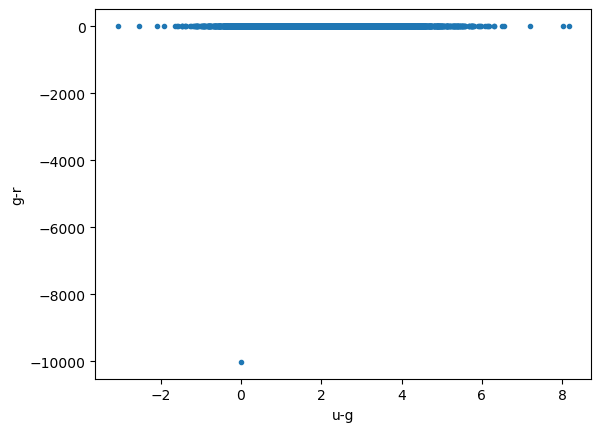

In [3]:
plt.figure()
plt.scatter(SDSSgals_df['ug'], SDSSgals_df['gr'], marker='.')
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.show()

The outlier sample is identified an removed from the set, 

In [4]:
outlier = SDSSgals_df.query('gr < -2000 or gi < -2000 or gz < -2000 or ug < -2000')
outlier

,ug,gr,gi,gz,petroRad_i,petroR50_i,deVAB_i
1852,0.0,-10017.78,-10017.15,0.0,3.623221,1.490871,0.696837


In [5]:
outlier.index[0]

1852

In [6]:
SDSSgals_df = SDSSgals_df.drop(outlier.index[0])

In order to train the ML algorithm, we transform the dataframe into a `NumPy` array,

In [7]:
X = np.array(SDSSgals_df)
X.shape

(9999, 7)

The final step in this pre-processing is to apply the [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) function to standardize the features. This is done by removing the mean and scaling to unit variance.

In [8]:
from sklearn.preprocessing import StandardScaler

galScaler = StandardScaler().fit(X)

X_train = galScaler.transform(X)
X_train

array([[-0.60469344,  0.17139934,  0.16071316, ..., -0.02367782,
         0.03771503, -0.40949881],
       [ 0.03099732,  0.90229472,  0.68628822, ..., -0.05834101,
         0.03717291,  1.26850057],
       [ 0.12721846, -0.75876348, -0.89661939, ...,  0.2104077 ,
         0.03969664,  1.27092675],
       ...,
       [-0.20256162,  0.35720152,  0.6409339 , ..., -0.13724876,
         0.03629949,  0.40498988],
       [ 2.49822399,  0.37538655,  0.29626585, ..., -0.11950793,
         0.03568864, -2.07033176],
       [ 2.40465984,  1.10220632,  0.63589764, ..., -0.24957706,
         0.03588054,  0.72612274]])

## The Clustering Algorithm

We will use the function [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) to find clusters (groups of points) into the dataset. This function performs a **DBSCAN** (**D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise) clustering from vector array or distance matrix. This method finds core samples of high density and expands clusters from them and therefore it is good for data which contains clusters of similar density.

We will use the following arguments:

- eps = 0.5 : Maximum distance between two samples for one to be considered as in the neighborhood of the other. 

- min_samples = 110 : The number of samples in a neighborhood for a point to be considered as a core point (including the point itself).

In [20]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps = 0.5, min_samples = 110)

dbs.fit(X_train)

cluster_members = dbs.labels_ != -1
outliers = dbs.labels_ == -1


The `.labels_` attribute contains the cluster labels for each point in the dataset. Noisy (or outliers) samples are given the label -1. 

Using this information, we can plot the ouliers  (noisy points),

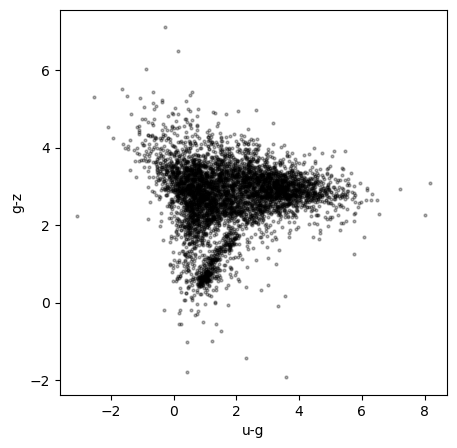

In [21]:
# Outliers plot

plt.figure(figsize = (5,5))
plt.scatter(X[:,0][outliers], X[:,3][outliers], 
            c = "k", 
            s = 4, alpha = 0.3)
#plt.xlim(-1,5)
#plt.ylim(-0,3.5)
plt.xlabel('u-g')
plt.ylabel('g-z')
plt.show()

The cluster points are given in the following figure,

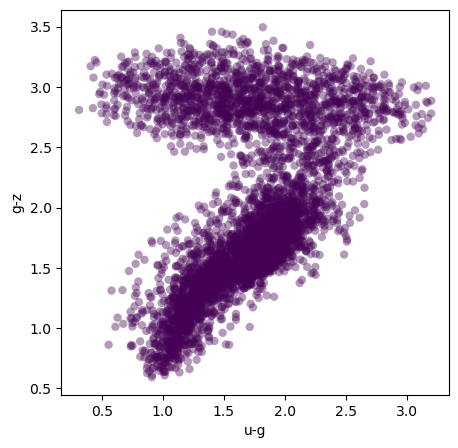

In [22]:
# Clusters plot

plt.figure(figsize = (5,5))
plt.scatter(X[:,0][cluster_members], X[:,3][cluster_members], 
            c = dbs.labels_[cluster_members], 
            alpha = 0.4, edgecolor = "None", cmap = "viridis")
#plt.xlim(-1,5)
#plt.ylim(-0,3.5)
plt.xlabel('u-g')
plt.ylabel('g-z')
plt.show()


A plot combining clusters and outliers gives a better understanding of the results,

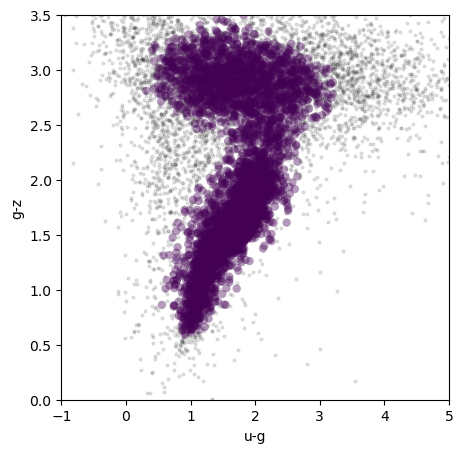

In [23]:
plt.figure(figsize = (5,5))
plt.scatter(X[:,0][outliers], X[:,3][outliers], 
            c = "k", 
            s = 4, alpha = 0.1)
plt.scatter(X[:,0][cluster_members], X[:,3][cluster_members], 
            c = dbs.labels_[cluster_members], 
            alpha = 0.4, edgecolor = "None", cmap = "viridis")
plt.xlim(-1,5)
plt.ylim(-0,3.5)
plt.xlabel('u-g')
plt.ylabel('g-z')
plt.show()


The above results seem to separate out elliptical galaxies from blue star forming galaxies. However, the results are highly dependent upon the tuning parameters. For example, you can play with the argument `min_samples` in the DBSCAN function to obtain different results (e.g. use the values in the range 90-150).